# Email from Jiwen

Hi Phil,
Sorry for the delay in passing the hydrometer size distribution data to you. 
For start, I provide the SD data from the May20 squall line case from MC3E in the following directory  on Constance (I will add you to project dcc_fan)
/pic/projects/dcc_fan/hanb924/Intercomparison/outputs/results_interactive_5minfreq/results_inter_sbmsd_5min

The file names starting with "inter_h02_d01_2011-05-20”. The squall line mature period is around 9:00-10:00 so you can choose the files between the times if you want to try the data during the mature period. You can choose the data in the earlier or later time period too (the data are in 5-min time frequency).

In each file, the variables ff1i01 to ff1i33 are the bins for liquid particles,  ff5i01 to ff5i33 for ice/snow bins in the fast version and ff6i01 to ff6i33 for graupel or hail bins. The unite are in kg/kg. if you want to transform to number concentration, you need to multiply by air density (unit:kg/m3) , then divided by mass of a single particle over the corresponding bin.  The mass of a single particle for each bin is in the file masses.asc (under the same folder). The file can be read as 
 XL(33),XI (3, 33),XS(33),XG(33),XH(33) for liquid, 3 types of ice crystals, snow, graupel, and hail. 
Please let me know if you have any questions about the data.

Thanks a lot,
Jiwen




In [2]:
%matplotlib inline
from pjr import *
import pprint

def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in xrange(0, len(l), n))

['DateStrLen', 'Time', 'south_north', 'west_east_stag', 'bottom_top_stag', 'bottom_top', 'west_east', 'south_north_stag']
type of varlist <type 'list'>
xyz is a max at (16, 341, 309)
coord to plot (using 0 based indexing) (4, 239, 266)
bnum [  4.04274184e-12   9.18401327e-11   6.21373022e-11   2.80898915e-10
   1.08457465e-09   4.18420854e-09   7.09620984e-09   3.55988625e-08
   3.49796210e-08   1.13041327e-08   1.33706851e-10   3.07206621e-10
   2.56711541e-10   4.60597616e-10   1.56230651e-09   7.41126760e-09
   3.85200778e-08   1.90358790e-07   6.83302517e-07   1.52349503e-06
   2.28876138e-06   2.94336087e-06   6.76116088e-06   1.31253601e-05
   2.88584615e-05   4.37078452e-05   6.48358036e-05   9.02901738e-05
   9.50410467e-05   5.04897689e-05   1.79656636e-05   5.66081962e-06
   4.86352462e-07]
revised bnum [  4.04274184e-12   9.18401327e-11   6.21373022e-11   2.80898915e-10
   1.08457465e-09   4.18420854e-09   7.09620984e-09   3.55988625e-08
   3.49796210e-08   1.13041327e-08   

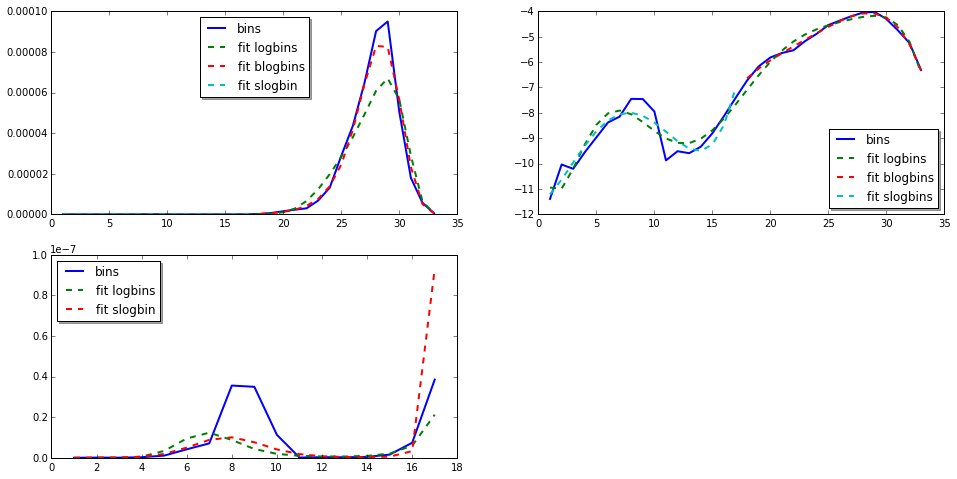

In [32]:
from numpy.polynomial.chebyshev import chebfit, chebval
#f = cdms2.open("/Users/d3x345/Desktop/NetCDF_files/inter_h02_d01_2011-05-20_14:30:00");
f = cdms2.open("/Users/d3x345/Desktop/NetCDF_files/inter_h02_d01_2011-05-20_10:00:00");
varlist = f.listvariables();
dims = f.listdimension();
print dims;
#print varlist;
print "type of varlist", type(varlist)
time = f['Time']
xc = f['west_east']
yc = f['south_north']
zc = f['bottom_top']
#print 'time', time
#print 'xc',xc
#print 'yc',yc
#print 'zc',zc


# access the 33 bins containing liquid
for index in range(1,34):
    fname = "ff1i"+str(index).zfill(2)
#    print fname
    V = f(fname)
#    print "shape", V.shape
#    print "range", V.min(), V.max()

# a first look shows that bin 28 has high mass, so lets find the coord where that occurs
V = f('ff1i28')
V0 = V[0]  # change from a transient array to a regular one
i,j,k = np.where(V0 == V0.max()) # indices of max value
xyz = zip(i,j,k)[0]
print "xyz is a max at", xyz
xyz = (5-1,240-1,267-1) # convert Kobby's mid level point to zero base indexing
#xyz = (7-1,240-1,267-1) # convert Kobby's upper point to zero base indexing

print "coord to plot (using 0 based indexing)", xyz

for index in range(1,34):
    fname = "ff1i"+str(index).zfill(2)
    V = f(fname)
    V0 = V[0]
    binval = V0[xyz]
#    print "index", index, type(index)
    if index == 1:
        bnum = np.array([binval])
    else:
        bnum = np.concatenate((bnum,np.array([binval])))
#    print "bnum.type", bnum, type(bnum)

print "bnum", bnum
#    print fname
#    V = f(fname)
#    print "shape", V.shape
#    print "range", V.min(), V.max()

# since we may want to use logarithms put a lower bound on mass
bmin = bnum.max()*1.e-10
bnum = np.maximum(bnum,bmin)

# convert to log base 10
bnuml = np.log10(bnum)
print "revised bnum", bnum

binind = np.array(range(1,34))  # coordinate for the absicca
print "binind is", binind

# fit the number 
ncoefs = 4 # number of coefficients per small or large size
cfall,info = chebfit(binind, bnum, 2*ncoefs, full=True)
fitall = chebval(binind,cfall)
cflog,info = chebfit(binind, bnuml, 2*ncoefs, full=True)
gitall = chebval(binind,cflog)

# split the full spectrum into two (small, large)
binisp = np.array_split(binind,2) # x coord
bnmvsp = np.array_split(bnum,2)  # N
bnmlsp = np.array_split(bnuml,2) # log N

bigxx = binisp[1] # x coordinate
bigyy = bnmvsp[1] # big drops
bigyl = bnmlsp[1] # in log space

smxx = binisp[0] # x coordinate
smyy = bnmvsp[0] # big drops
smyl = bnmlsp[0] # in log space
nsmall = len(smxx)
print "smxx", smxx
print "smxx[0:nsmall]", smxx[0:nsmall]

# do the fitting of the big particles
d,info = chebfit(bigxx, bigyy, ncoefs, full=True) # coefs in N space
dl,info = chebfit(bigxx, bigyl, ncoefs, full=True) # coefs in log space
bfitf = chebval(bigxx,d) # fit in N space
bfitfl = chebval(bigxx,dl) # fit in Log space
bfitfl = 10.**bfitfl # transform back to N space
print "bigxx", bigxx
print "bigyy", bigyy
# print "bfitf", bfitf
print "bfitfl", bfitfl

# do the fitting of the small particles
e,info = chebfit(smxx, smyy, ncoefs, full=True) # coefs in N space
cfsml,info = chebfit(smxx, smyl, ncoefs, full=True) # coefs in log space
cfsmlt = np.copy(cfsml)
print "cfsml v0", cfsml
# cfsmlt[3:len(cfsmlt)]= 0.
print "cfsml v1", cfsml
print "cfsmlt", cfsmlt
sfitf = chebval(smxx,e) # fit in N space
sfitfl = chebval(smxx,cfsml) # fit in Log space
print "sfitfl V0", sfitfl
sfitfl = 10.**sfitfl # transform back to N space
sfitflt = chebval(smxx,cfsmlt)
print "sfitflt V0xx", sfitflt
sfitflt = 10.**sfitflt # transform back to N space

print "smxx", smxx
print "smyy", smyy
print "sfitf", sfitf
print "sfitfl", sfitfl
print "sfitflt", sfitflt



plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.rc('lines', linewidth=2)
plt.plot(binind, bnum, label='bins')
#plt.plot(x, y, '--', linewidth=2)

# plt.plot(binind, fitall,'--',label='fit bins')
#plt.plot(binxx, bfitf,'--')
plt.plot(binind, 10**gitall, '--',label='fit logbins')
plt.plot(bigxx, bfitfl,'--',label='fit blogbins')
#plt.plot(smxx, sfitf,'--',label='fit sbins')
plt.plot(smxx, sfitfl,'--',label='fit slogbin')
plt.legend(loc='upper center', shadow=True)

plt.subplot(223)
plt.rc('lines', linewidth=2)
plt.plot(binind[0:nsmall], bnum[0:nsmall], label='bins')
#plt.plot(x, y, '--', linewidth=2)

# plt.plot(binind, fitall,'--',label='fit bins')
#plt.plot(binxx, bfitf,'--')
plt.plot(binind[0:nsmall], 10**gitall[0:nsmall], '--',label='fit logbins')
#plt.plot(smxx, sfitf,'--',label='fit sbins')
plt.plot(smxx, sfitfl,'--',label='fit slogbin')
plt.legend(loc='upper left', shadow=True)

print "cfall coefs are ", cfall
print "cflog coefs are ", cflog
print "d coefs are ", d
print "cfsml coefs are ", cfsml
# info contain, residual, rank, singular values, condition number
# print "info is", info
plt.subplot(222)
plt.plot(binind, np.log10(bnum),label='bins')
plt.plot(binind, gitall, '--',label='fit logbins')
plt.plot(bigxx, np.log10(bfitfl),'--',label='fit blogbins')
plt.plot(smxx, np.log10(sfitfl),'--',label='fit slogbins')
plt.legend(loc='lower right', shadow=True)
plt.show()


In [15]:
x = np.arange(9.0)
print "xx",type(x),len(x)
print x

xx <type 'numpy.ndarray'> 9
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]
